In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the data
df_ab_test = pd.read_csv('/content/ab_test_click_data (1).csv')

In [ ]:
print(df_ab_test.head())

   user_id  click group            timestamp
0        1      1   exp  2024-01-01 00:00:00
1        2      0   exp  2024-01-01 00:01:00
2        3      1   exp  2024-01-01 00:02:00
3        4      0   exp  2024-01-01 00:03:00
4        5      1   exp  2024-01-01 00:04:00


In [ ]:
print(df_ab_test.describe())

            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000


In [ ]:
print(df_ab_test.groupby('group').sum('click'))

         user_id  click
group                  
con    150005000   1989
exp     50005000   6116


A simple bar chart showing the total click versus no-clicks in each group can provide a clear visual comparion of user engagement

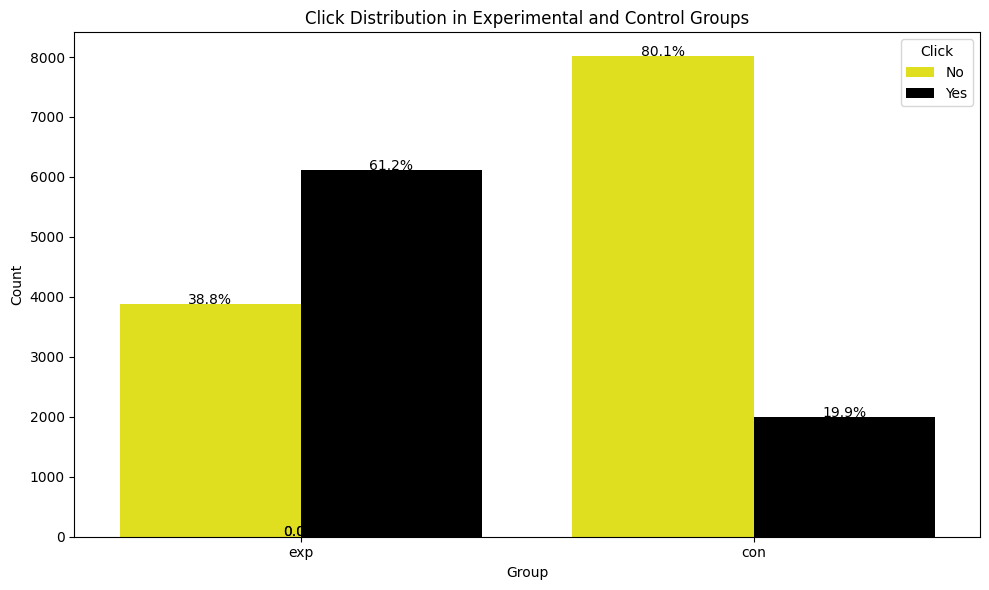

In [ ]:
# Custom palette for yellow and black
palette = {0: 'yellow', 1: 'black'}  # Assuming 0 is for no-click, 1 for click

# Plotting the click distribution for each group with the custom colors
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='group', hue='click', data=df_ab_test, palette=palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click', labels=['No', 'Yes'])

# Calculate the percentages and annotate the bars
group_counts = df_ab_test.groupby('group').size()
group_click_counts = df_ab_test.groupby(['group', 'click']).size().reset_index(name='count')

for p in ax.patches:
    height = p.get_height()
    # Find the group and click type for the current bar
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width() / 2., height + 5,
            f'{percentage:.1f}%', ha="center", color='black', fontsize=10)


plt.tight_layout()
plt.show()



## **Parameters of the Model from Power Analysis**
- **β**: Probability of Type II Error  
- **(1 - β)**: Power of the test  
- **α**: Probability of Type I Error (Significance Level)  
- **δ**: Minimum Detectable Effect  


In [ ]:
alpha = 0.05
print("Alpha: significance level is:", alpha)

delta = 0.1

print("Delta: minimum detectable  effect is:",delta)

Alpha: significance level is: 0.05
Delta: minimum detectable  effect is: 0.1


In [ ]:
N_con = df_ab_test[df_ab_test["group"] == "con"].count()
N_exp = df_ab_test[df_ab_test["group"] == "exp"].count()

# Calculating the total number of clicks per group by summing 1's
X_con = df_ab_test.groupby("group")["click"].sum().loc["con"]
X_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]

# Printing this for visibility
print(df_ab_test.groupby("group")["click"].sum())  # Displays total clicks per group
print("Number of Users in Control: ", N_con)
print("Number of Users in Experimental: ", N_exp)
print("Number of Clicks in Control: ", X_con)
print("Number of Clicks in Experimental: ", X_exp)


group
con    1989
exp    6116
Name: click, dtype: int64
Number of Users in Control:  user_id      10000
click        10000
group        10000
timestamp        0
dtype: int64
Number of Users in Experimental:  user_id      10000
click        10000
group        10000
timestamp    10000
dtype: int64
Number of Clicks in Control:  1989
Number of Clicks in Experimental:  6116


In [ ]:
# Computing the estimate of click probability per group
p_con_hat = X_con / N_con
p_exp_hat = X_exp / N_exp

print("Click Probability in Control Group:", p_con_hat)
print("Click Probability in Experimental Group:", p_exp_hat)

# Computing the estimate of pooled clicked probability
p_pooled_hat = (X_con + X_exp) / (N_con + N_exp)
print("Pooled Click Probability:", p_pooled_hat)


Click Probability in Control Group: user_id      0.1989
click        0.1989
group        0.1989
timestamp       inf
dtype: float64
Click Probability in Experimental Group: user_id      0.6116
click        0.6116
group        0.6116
timestamp    0.6116
dtype: float64
Pooled Click Probability: user_id      0.40525
click        0.40525
group        0.40525
timestamp    0.81050
dtype: float64


In [ ]:
# Computing the estimate of pooled variance
pooled_variance = p_pooled_hat * (1 - p_pooled_hat) * (1/N_con + 1/N_exp)

print("p^_pooled is: ", p_pooled_hat)
print("pooled_variance is: ", pooled_variance)


p^_pooled is:  user_id      0.40525
click        0.40525
group        0.40525
timestamp    0.81050
dtype: float64
pooled_variance is:  user_id      0.000048
click        0.000048
group        0.000048
timestamp         inf
dtype: float64


##**Calculating Standard Error and Test Statistics**


In [ ]:
# Computing the standard error of the test
SE = np.sqrt(pooled_variance)
print("Standard Error is: ", SE)

# Computing the test statistics of Z-test
Test_stat = (p_con_hat - p_exp_hat) / SE
print("Test Statistics for 2-sample Z-test is:", Test_stat)

# Critical value of the Z-test
Z_crit = norm.ppf(1 - alpha/2)
print("Z-critical value from Standard Normal distribution:", Z_crit)


Standard Error is:  user_id      0.006943
click        0.006943
group        0.006943
timestamp         inf
dtype: float64
Test Statistics for 2-sample Z-test is: user_id     -59.441633
click       -59.441633
group       -59.441633
timestamp          NaN
dtype: float64
Z-critical value from Standard Normal distribution: 1.959963984540054


##**Calculating p_values of the Z-test**

In [ ]:
#calculating p value
p_value = 2 * norm.sf(abs(Test_stat))

# function checking the statistical significance
def is_statistical_significance(p_value, alpha):
    """
    We assess whether there is statistical significance based on the p-value and alpha.

    Arguments:
    - p_value (float): The p-value resulting from a statistical test.
    - alpha (float, optional): The significance level threshold used to determine statistical significance. Defaults to 0.05.

    Returns:
    - Prints the assessment of statistical significance.
    """

    # Print the rounded p-value to 3 decimal places
    # Access the first element of the p-value array (assuming it's the relevant p-value)
    print(f"P-value of the 2-sample Z-test: {round(float(p_value[0]), 3)}")

    # Determine statistical significance using the first element of the p-value array
    if p_value[0] < alpha:
        print("There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance.")
    else:
        print("There is no statistical significance, suggesting that the observed differences between the groups could have occurred by chance.")

is_statistical_significance(p_value, alpha)

P-value of the 2-sample Z-test: 0.0
There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance.


##**Calculating Confidence Interval of the test**

In [ ]:
# Calculate the Confidence Interval (CI) for a 2-sample Z-test
## Calculate the lower and upper bounds of the confidence interval
CI = [
    round((p_exp_hat - p_con_hat) - SE * Z_crit, 3),  # Lower bound of the CI, rounded to 3 decimal places
    round((p_exp_hat - p_con_hat) + SE * Z_crit, 3)   # Upper bound of the CI, rounded to 3 decimal places
]

# Print the calculated confidence interval
print("Confidence Interval of the 2 sample Z-test is:", CI)

# Here, the confidence interval provides a range of values within which the true difference between the experimental and control group p


Confidence Interval of the 2 sample Z-test is: [user_id      0.399
click        0.399
group        0.399
timestamp     -inf
dtype: float64, user_id      0.426
click        0.426
group        0.426
timestamp      NaN
dtype: float64]


##**Testing for practical Significance**

In [ ]:
def is_Practically_significant(delta, CI_95):
    """
    We assess here if the difference between Control and Experimental group is practically significant using the Minimum Detectable Effect (MDE).

    Arguments:
    - delta (float): The Minimum Detectable Effect (MDE) considered for practical significance.
    - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% Confidence Interval.

    Returns:
    - Prints whether the experiment has practical significance based on the MDE and CI.
    """

    # Extract lower bound of 95% Confidence Interval
    lower_bound_CI = CI_95[0]

    # Check if the lower bound of the CI is greater than or equal to delta
    if delta >= lower_bound_CI:
        print(f"We have practical significance!\nWith MDE of {delta}, the difference between Control and Experimental group is practically significant.")
        return True
    else:
        print("We don't have practical significance!\nThe difference between Control and Experimental group is not practically significant.")
        return False

# Example of using the function
delta = 0.05  # Assuming a 5% increase is our MDE
CI_95 = (0.04, 0.06)  # Example Confidence Interval

# Call the function
significance = is_Practically_significant(delta, CI_95)
print("Lower bound of 95% confidence interval is:", CI_95[0])


We have practical significance!
With MDE of 0.05, the difference between Control and Experimental group is practically significant.
Lower bound of 95% confidence interval is: 0.04
